# Homework 11

In class, we discussed various forms of position embeddings for self-attention in Transformers. One kind of position embedding we discussed in class is a relative position embedding, where we associate each offset $\Delta = t - i$ between position query position $t$ and key position $i$ with a scalar $e_\Delta$ that gets added to the output of the comparison function as $\alpha(q_t, k_i) + e_\Delta$. This is the type of position embedding used in [ALIBI](https://arxiv.org/abs/2108.12409) and [T5](https://arxiv.org/abs/2108.12409).

# Problem 1

In the T5 model, there is a single set of attention "bias" values ($e_\Delta$) shared across all layers in the encoder (and another set shared across all layers in the decoder). Each attention head (of which there are 12)has its own set of bias values. The offsets in the bias values are logarithmically spaced, and there are 32 total bias values.

Below you will find code for loading the [`t5-base`](https://huggingface.co/t5-base) model from the Hugging Face Model Hub and grabbing the tensor for the attention biases in the encoder. You'll also find a funcion that maps from an offset ($\Delta$) and returns an index into the attention bias tensor. So, for example, if you wanted to get the bias for query index `t` and key index `i`, you could do `biases[relative_position_bucket(t - i)]`.

1. Using this tensor and function, plot images (e.g. using `plt.imshow`) that show the relative attention bias for each offset. Your x-axis should be the query index from 0 to 128, your y-axis should be the key index from 0 to 128, and the color in the image should represent the bias.

1. Pick one of the bias images for one of the heads that looks interpretable and explain what it is causing the model to do (i.e. which positions is it increasing or decreasing the attention values for).

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.4 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, T5Model
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
    """
    Adapted from Mesh Tensorflow:
    https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593
    Translate relative position to a bucket number for relative attention. 
    
    The relative position is defined as memory_position - query_position, i.e. the distance in tokens 
    from the attending position to the attended-to position. If bidirectional=False, then positive relative positions are invalid. 
    We use smaller buckets for small absolute relative_position and larger buckets for larger absolute relative_positions. 
    All relative positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
    This should allow for more graceful generalization to longer sequences than the model has been trained on
    
    Args:
        relative_position: an int32 Tensor
        bidirectional: a boolean - whether the attention is bidirectional
        num_buckets: an integer
        max_distance: an integer
    
    Returns:
        a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
    """
    relative_buckets = 0
    if bidirectional:
        num_buckets //= 2
        relative_buckets += (relative_position > 0).to(torch.long) * num_buckets
        relative_position = torch.abs(relative_position)
    else:
        relative_position = -torch.min(relative_position, torch.zeros_like(relative_position))
    # now relative_position is in the range [0, inf)

    # half of the buckets are for exact increments in positions
    max_exact = num_buckets // 2
    is_small = relative_position < max_exact

    # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
    relative_position_if_large = max_exact + (
        torch.log(relative_position.float() / max_exact)
        / math.log(max_distance / max_exact)
        * (num_buckets - max_exact)
    ).to(torch.long)
    relative_position_if_large = torch.min(
        relative_position_if_large, torch.full_like(relative_position_if_large, num_buckets - 1)
    )

    relative_buckets += torch.where(is_small, relative_position, relative_position_if_large)
    return relative_buckets


model = T5Model.from_pretrained("t5-base")
biases = model.get_parameter("encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight").detach().numpy()

In [3]:
def plot_attention_head_biases(query_dim, key_dim, head_idx, bias_weights=biases):
    """
    Plots the relative attention bias for each offset.
    """
    attention_biases = np.zeros([query_dim, key_dim])

    # Loop over Query/Key Positions
    for t in range(query_dim):
        for i in range(key_dim):
            # Calculate Relative Positive 
            delta = t - i
            # Get index of Attention Bias
            idx = relative_position_bucket(torch.tensor(delta))
            # Add Value to Image Matrix
            attention_biases[t, i] = biases[:, head_idx][idx]

    # Plot the attention biases
    plt.imshow(attention_biases, cmap='coolwarm')
    plt.colorbar()
    plt.xlabel('Query Index')
    plt.ylabel('Key Index')
    plt.title('Attention Biases')
    plt.show()

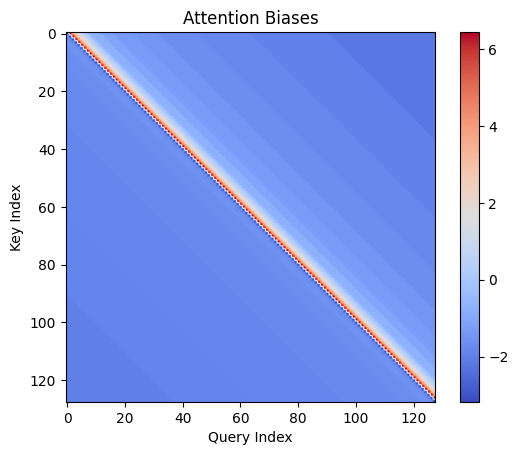

In [4]:
plot_attention_head_biases(128, 128, 1)

**Written Answer**: The above is an interesting attention bias map as it shows very short term attetntion. As we can see from the above, the red band is just above the diagonal indication that those values place high bias on the key indices just before the current query index. We can also see evidence of the logarithmic spacing of buckets looking diagonally at the spans of the different color bands. 

# Problem 2

Consider a one-dimensional convolution of a filter $[w_1, w_2, w_3]$ against a sequence $[x_1, x_2, x_3, x_4]$ with a padding of 1 and stride of 1. The output of this convolution is
\begin{align}
 [&w_2 x_1 + w_3 x_2, \\
 &w_1 x_1 + w_2 x_2 + w_3 x_3, \\
 &w_1 x_2 + w_2 x_3 + w_3 x_4, \\
 &w_1 x_3 + w_2 x_4] \end{align}
In addition, consider the general form of the "relative attention bias" approach, where $ e_\Delta$ gets added to the output of the comparison function as $\alpha(q_t, k_i) + e_\Delta$. Design an attention mechanism using relative attention bias that produces the same output the convolution described above. You can set $e_\Delta$ however you choose, i.e. don't assume they are learned. Hint: Remember, you also get to decide what the queries, keys, values, comparison function, and reduction function are. They can be whatever you want! E.g. the reduction function doesn't need to have a softmax and the comparison function's output can be constant.

**Written Answer**: The following implementation shows my take on replicating the effect of passing a 1-D convolution using a filter of size 3 on the input of size 4 by using an attention mechanism with the standard features. Mapping the computation from thet convolution to an attention mechanism was done, yielding the following:

* Map from Input to Query: Take a query vector q, which is the convolutional filter and return this constant value for any input.

* Map from Input to Key: As we will see in the implementation of the comparison function, the value of the key is not relevant, so I chose to use the Identity() operator as the Key Map. However, taking a page out of the attention pooling HW, and if we want to follow the general practices of keepign the key and value dimension identical, we can also assign the key to be equivalent to the value, implemented below.

* Map from Input to Value: In order to replicate the computation from a convolution with stride=1 AND padding=1, I set the value equal to the input sequence with the padding applied.

* Comparison Function: The comparison function takes its from from the implementation of the reduction function below. In order to perform the convolution operation to get the same output as the above, the comparison function needs to return the query values, regardless of what the input is.

* Reduction Function: The reduction function takes the outputs from the comparison functions and returns an "attention" weighted transformation on the values. Here is where I defined the convolution operator to take the convolutional weights (in this case the queries) and get the cross-correlation  over the input sequence.

I implemented the above strategy as an attention mechanism and used a random convolutional filter and random input to test that the outputs were equivalent.

In [5]:
# Define An Arbitrary Convolutional Filter
w = torch.rand(3)
# Define An Arbitrary Input
x = torch.rand(4)

In [6]:
# Sanity Check The Manual Version
z1 = w[1]*x[0] + w[2]*x[1]
z2 = w[0]*x[0] + w[1]*x[1] + w[2]*x[2]
z3 = w[0]*x[1] + w[1]*x[2] + w[2]*x[3]
z4 = w[0]*x[2] + w[1]*x[3]

torch.tensor([z1, z2, z3, z4])

tensor([0.4070, 0.6126, 0.5321, 0.2838])

In [7]:
# Test That the Convolutional Layer Gives the Same Output
conv = torch.nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
conv.weight = torch.nn.Parameter(w.unsqueeze(0).unsqueeze(0))
conv(x.unsqueeze(0).unsqueeze(0))

tensor([[[0.4070, 0.6126, 0.5321, 0.2838]]], grad_fn=<ConvolutionBackward0>)

In [15]:
class CustomAttn:
    """
    Define a Custom Attention Module

    Args:
        query_map: Map input to query 
        key_map: Map input to key
        value_map: Map input to value
        comparison_fxn: Compare Key to Query
        reduction_fxn: Reduction Function

    Returns:
        attn_weighted_inp: Transformed inputs that are now attention weighted
    """

    def __init__(self,
                 comparison_fxn,
                 reduction_fxn,
                 query_map=None,
                 query_weights=None,
                 key_map=None,
                 value_map=None,
                 ):
        self.reduction = reduction_fxn
        self.comparison = comparison_fxn
        self.query_map = query_map
        self.q_weights = query_weights
        self.key_map = key_map
        self.value_map = value_map
        
    def forward(self, inputs):
        queries = self.query_map(inputs, self.q_weights)
        keys = self.key_map(inputs)
        values = self.value_map(inputs)
        alpha = self.comparison(queries, keys)
        outs = self.reduction(alpha, values)
        return outs

In [9]:
def query_mapper(inputs, weights=None):
        return weights
            
def conv_map(inputs, padding="bidirectional", padding_len=1, padding_value=0):
    """
    Treat the mapping of Inputs [batch_size, input_dim] to inputs that are 
    traditionally passed into convolutional layers by applying padding to them.
    """
    if padding == "bidirectional":
        pad = (padding_len, padding_len)
    elif padding == "left":
        pad = (padding_len, 0)
    elif padding == "right":
        pad = (0, padding_len)

    padded_tensor = F.pad(inputs, pad, "constant", value=padding_value)

    return padded_tensor

In [14]:
def dummy_comparison_function(queries, keys, good_vibes=True):
    """
    Define a dummy comparison function that checks if the
    vibes are good and then simply outputs the query vector
    """
    assert good_vibes==True
    return queries

def  conv_reduction_fxn(comparisons, values, stride=1):
    """
    Perform 1-D Convolution [Cross-Correlation] Between
    The Query Vector and the Key Vector to get the Similarity

    Args:
        queries: query vector 
        values: value vector (bsz, key_dim)

    Returns:
        sims: similarity vectors
    """

    batch_size, input_dim = values.size()
    _, kernel_size = comparisons.shape

    output_dim = (input_dim - kernel_size)//stride + 1
    sims = torch.zeros([batch_size, output_dim])


    for b in range(batch_size):
        for i in range(0, input_dim - kernel_size + 1, stride):
            input_window = values[b, i:i+kernel_size]
            sims[b, i//stride] = torch.sum(input_window * comparisons[:, :])     
    return sims



In [16]:
ConvAttn = CustomAttn(dummy_comparison_function, conv_reduction_fxn, query_map=query_mapper, query_weights=w.unsqueeze(0), key_map=nn.Identity(), value_map=conv_map)
ConvAttn.forward(x.unsqueeze(0))

tensor([[0.4070, 0.6126, 0.5321, 0.2838]])